# Import data

In [ ]:
import pandas as pd
sales=pd.read_csv("data_processed.csv")
sales

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,2018-08-27,44,20.0,53.99,42.38,43.99,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4308,2018-09-03,44,14.0,52.99,53.99,42.38,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4309,2018-09-10,44,22.0,44.99,52.99,53.99,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4310,2018-09-17,44,28.0,42.99,44.99,52.99,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
res=pd.DataFrame(index=['R2']) #useful to gather results and visualize them
res

""
R2


Structure dataset:

In [ ]:
import numpy as np

## Structure ##
skuSet = list(sales.sku.unique())
skuData = {}
colnames = [i for i in sales.columns if i not in ["week","weekly_sales","sku"] ]
for i in skuSet:
  df_i = sales[sales.sku == i]
  skuData[i] = {'X': df_i[colnames].values,
                'y': df_i.weekly_sales.values}

## Decentralized ##
X_dict = {}
y_dict = {}

y_test = []
y_train = []

for i in skuSet:

  X_train_i,X_test_i = np.split(skuData[i]["X"], [68]) #split for X
  y_train_i,y_test_i = np.split(skuData[i]["y"], [68]) #split for y 

  X_dict[i] = {'train': X_train_i, 'test': X_test_i} #filling dictionary
  y_dict[i] = {'train': y_train_i, 'test': y_test_i}

  y_test += list(y_test_i) #creating the complete training array
  y_train += list(y_train_i) #creating the complete testing array

## Centralized ##
X_cen_train = X_dict[skuSet[0]]['train'] #initialization with item 0
X_cen_test = X_dict[skuSet[0]]['test']

for i in skuSet[1:]: #Iteration over items
    X_cen_train = np.concatenate((X_cen_train, X_dict[i]['train']), axis = 0) #Bringing together the training set
    X_cen_test = np.concatenate((X_cen_test, X_dict[i]['test']), axis = 0)

Building and structuring subsets:

In [ ]:
X_dict_subsplit = {} 
y_dict_subsplit = {} 

y_validation = [] 
y_subtrain = [] 

for i in skuSet:
  
  X_train_i,X_test_i = np.split(X_dict[i]["train"], [48]) #split for X
  y_train_i,y_test_i = np.split(y_dict[i]["train"], [48]) #split for y 

  X_dict_subsplit[i] = {'train': X_train_i, 'test': X_test_i} #filling dictionary
  y_dict_subsplit[i] = {'train': y_train_i, 'test': y_test_i}

  y_validation += list(y_test_i) #creating the complete training array
  y_subtrain += list(y_train_i) #creating the complete testing array

## Centralized data
X_cen_subtrain = X_dict_subsplit[skuSet[0]]['train'] #initialization with item 0 #X_cen_train_sub
X_cen_validation = X_dict_subsplit[skuSet[0]]['test'] #X_cen_test_sub
for i in skuSet[1:]: #Iteration over items
    X_cen_subtrain = np.concatenate((X_cen_subtrain, X_dict_subsplit[i]['train']), axis = 0) #Bringing together the training set
    X_cen_validation = np.concatenate((X_cen_validation, X_dict_subsplit[i]['test']), axis = 0)

In [ ]:
#y_validation_ = [] 
#y_subtrain_ = [] 

#for i in skuSet:
#  
#  X_train_i, X_test_i = train_test_split(X_dict[i]["train"], shuffle=False, train_size=0.7) #split for X
#  y_train_i, y_test_i = train_test_split(y_dict[i]["train"], shuffle=False, train_size=0.7) #split for y 
#
#  X_dict_subsplit[i] = {'train': X_train_i, 'test': X_test_i} #filling dictionary
#  y_dict_subsplit[i] = {'train': y_train_i, 'test': y_test_i}
#
#  y_validation_ += list(y_test_i) #creating the complete training array
#  y_subtrain_ += list(y_train_i) #creating the complete testing array

# IV/ Clustering

## 1) K-Means

### a) Just with sales and prices

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
scaler = MinMaxScaler()

In [ ]:
num_clusters=0
maximum_score=-100
oos_r2=0

## Iterations to find optimal parameter
for z in range(2,15):
  #Clustering
  X_clus = np.zeros((len(skuSet), 2))
  count = 0
  for sku in skuSet:
    X_clus[count, :] = np.mean( np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                 np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                 axis=1),
                                axis = 0 )
    count += 1
  X_clus = scaler.fit_transform(X_clus)
  kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
  #Loop
  y_clus_pred = [] #y_clus_pred_sub
  y_clus_validation = [] #y_clus_test_sub
  for j in range(z):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(kmeans.labels_ == j)[0])
    ##Initialization 
    #X_sub
    X_clus_j_subtrain = X_dict_subsplit[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster 
    X_clus_j_validation = X_dict_subsplit[skuSet[clus_items[0]]]['test'] 
    #y_sub
    y_clus_j_subtrain = list(y_dict_subsplit[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster 
    y_clus_j_validation = list(y_dict_subsplit[skuSet[clus_items[0]]]['test']) 
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
      sku=skuSet[idx]
      #X_sub
      X_clus_j_subtrain = np.concatenate((X_clus_j_subtrain, X_dict_subsplit[sku]['train']), axis = 0)
      X_clus_j_validation = np.concatenate((X_clus_j_validation, X_dict_subsplit[sku]['test']), axis = 0)
      #y_sub
      y_clus_j_subtrain += list(y_dict_subsplit[sku]['train'])
      y_clus_j_validation += list(y_dict_subsplit[sku]['test'])
    ##Model
    model_clus_j_sub = LinearRegression().fit(X_clus_j_subtrain, y_clus_j_subtrain)
    y_clus_pred += list(model_clus_j_sub.predict(X_clus_j_validation))
    y_clus_validation += y_clus_j_validation

  #Comparison of results
  score=r2_score(y_clus_validation, y_clus_pred)
  print('Number of clusters:',z,'- Validation R2:',score)
  if score > maximum_score:
    num_clusters=z
    maximum_score = score

#### Test on fresh data ####

z=num_clusters
#Clustering
X_clus = np.zeros((len(skuSet), 2))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                 np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                 axis=1),
                                axis = 0 )
    count += 1
X_clus = scaler.fit_transform(X_clus)
kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(z):
  ##Get indices of items in cluster j 
  clus_items = list(np.where(kmeans.labels_ == j)[0])
  ##Initialization 
  #X
  X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
  X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
  #y
  y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
  y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
  ##Loop 
  for idx in clus_items[1:]: #Iteration over items
    sku=skuSet[idx]
    #X
    X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
    X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
    #y
    y_clus_j_train += list(y_dict[sku]['train'])
    y_clus_j_test += list(y_dict[sku]['test'])
  ##Model
  model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
  y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
  y_clus_test += y_clus_j_test
#Results
oos_r2=r2_score(y_clus_test, y_clus_pred)

#### Print Results ####

print('\nBest Model:')
print('Number of clusters:',num_clusters)
print('Validation R2:', maximum_score)
print('OOS R2:', oos_r2)

Number of clusters: 2 - Validation R2: 0.007040241539366776
Number of clusters: 3 - Validation R2: 0.06842990458055465
Number of clusters: 4 - Validation R2: 0.0760145340588192
Number of clusters: 5 - Validation R2: 0.25103590781099616
Number of clusters: 6 - Validation R2: 0.2228659097349075
Number of clusters: 7 - Validation R2: 0.22524687672395172
Number of clusters: 8 - Validation R2: 0.26972220870047736
Number of clusters: 9 - Validation R2: 0.2646929914909625
Number of clusters: 10 - Validation R2: 0.2540314958812875
Number of clusters: 11 - Validation R2: 0.2292522613101008
Number of clusters: 12 - Validation R2: 0.2217356979655999
Number of clusters: 13 - Validation R2: 0.2218222158083144
Number of clusters: 14 - Validation R2: 0.2220351053131152

Best Model:
Number of clusters: 8
Validation R2: 0.26972220870047736
OOS R2: 0.5661477112672808


In [ ]:
import time
tZero=time.time()

#Clustering
z = 8
X_clus = np.zeros((len(skuSet), 2))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                 np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                 axis=1),
                                axis = 0 )
    count += 1
X_clus = scaler.fit_transform(X_clus)
kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)

#Loop
y_clus_pred = []
y_clus_test = []
for j in range(z):
  ##Get indices of items in cluster j 
  clus_items = list(np.where(kmeans.labels_ == j)[0])
  ##Initialization 
  #X
  X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
  X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
  #y
  y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
  y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
  ##Loop 
  for idx in clus_items[1:]: #Iteration over items
    sku=skuSet[idx]
    #X
    X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
    X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
    #y
    y_clus_j_train += list(y_dict[sku]['train'])
    y_clus_j_test += list(y_dict[sku]['test'])
  ##Model
  model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
  y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
  y_clus_test += y_clus_j_test

#Results
print('OOS R2:',r2_score(y_clus_test, y_clus_pred))

t = time.time()-tZero
print("Time to compute",t)

OOS R2: 0.5661477112672808
Time to compute 0.07438850402832031


In [ ]:
res['K-means - average']=[r2_score(y_clus_test, y_clus_pred)]
res

,K-means - average
R2,0.566148


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

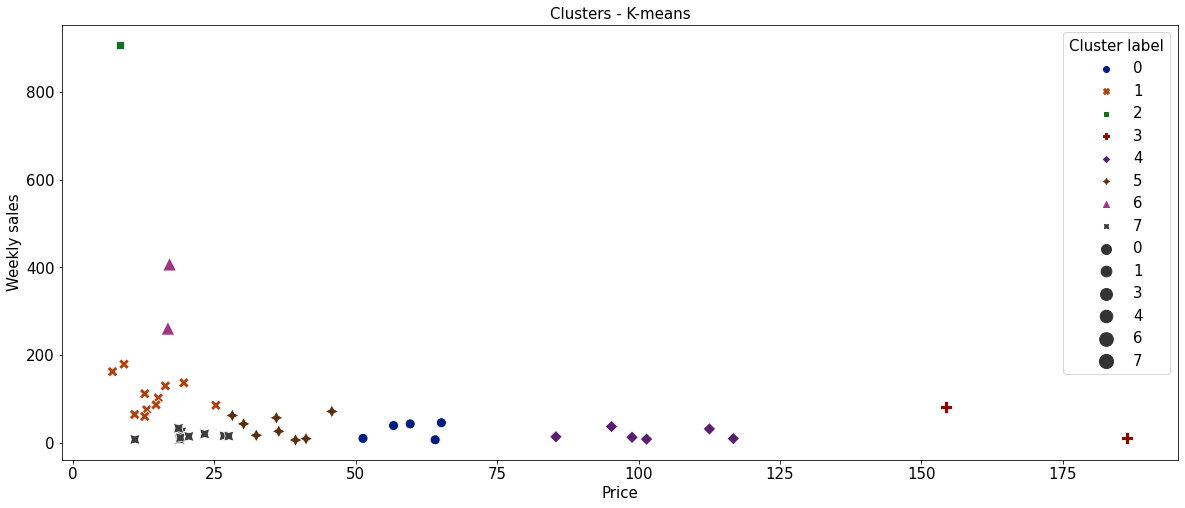

In [ ]:
## Build dataframe
list_prices=[]
list_sales=[]
for sku in skuSet:
  list_prices.append(np.mean(X_dict[sku]['train'][:,0], axis = 0))
  list_sales.append(np.mean([ [i] for i in y_dict[sku]['train'] ]))
df_clus=pd.DataFrame()
df_clus['price']=list_prices
df_clus['weekly_sales']=list_sales
df_clus['Cluster label']=labels=kmeans.labels_
## Plot
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,8))
graph = sns.scatterplot(data=df_clus, x="price", y="weekly_sales", 
                        hue="Cluster label", style="Cluster label", palette="dark",
                        size="Cluster label", sizes=(100, 200))
plt.title('Clusters - K-means', fontsize=15)
plt.xlabel("Price")
plt.ylabel("Weekly sales")
plt.savefig("clusters_kmeans.png",dpi=400)
plt.show()

### b) Mean and stdev of sales and prices

In [ ]:
num_clusters=0
maximum_score=-100
oos_r2=0

## Iterations to find optimal parameter
for z in range(2,15):
  #Clustering
  d = len(colnames) #d is the number of columns
  X_clus = np.zeros((len(skuSet), 4))
  count = 0
  for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
  X_clus = scaler.fit_transform(X_clus)
  kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
  #Loop
  y_clus_pred = [] #y_clus_pred_sub
  y_clus_validation = [] #y_clus_test_sub
  for j in range(z):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(kmeans.labels_ == j)[0])
    ##Initialization 
    #X_sub
    X_clus_j_subtrain = X_dict_subsplit[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster 
    X_clus_j_validation = X_dict_subsplit[skuSet[clus_items[0]]]['test'] 
    #y_sub
    y_clus_j_subtrain = list(y_dict_subsplit[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster 
    y_clus_j_validation = list(y_dict_subsplit[skuSet[clus_items[0]]]['test']) 
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
      sku=skuSet[idx]
      #X_sub
      X_clus_j_subtrain = np.concatenate((X_clus_j_subtrain, X_dict_subsplit[sku]['train']), axis = 0)
      X_clus_j_validation = np.concatenate((X_clus_j_validation, X_dict_subsplit[sku]['test']), axis = 0)
      #y_sub
      y_clus_j_subtrain += list(y_dict_subsplit[sku]['train'])
      y_clus_j_validation += list(y_dict_subsplit[sku]['test'])
    ##Model
    model_clus_j_sub = LinearRegression().fit(X_clus_j_subtrain, y_clus_j_subtrain)
    y_clus_pred += list(model_clus_j_sub.predict(X_clus_j_validation))
    y_clus_validation += y_clus_j_validation

  #Comparison of results
  score=r2_score(y_clus_validation, y_clus_pred)
  print('Number of clusters:',z,'- Validation R2:',score)
  if score > maximum_score:
    num_clusters=z
    maximum_score = score

#### Test on fresh data ####

z=num_clusters
#Clustering
d = len(colnames) #d is the number of columns
X_clus = np.zeros((len(skuSet), 4))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
X_clus = scaler.fit_transform(X_clus)
kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(z):
  ##Get indices of items in cluster j 
  clus_items = list(np.where(kmeans.labels_ == j)[0])
  ##Initialization 
  #X
  X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
  X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
  #y
  y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
  y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
  ##Loop 
  for idx in clus_items[1:]: #Iteration over items
    sku=skuSet[idx]
    #X
    X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
    X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
    #y
    y_clus_j_train += list(y_dict[sku]['train'])
    y_clus_j_test += list(y_dict[sku]['test'])
  ##Model
  model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
  y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
  y_clus_test += y_clus_j_test
#Results
oos_r2=r2_score(y_clus_test, y_clus_pred)

#### Print Results ####

print('\nBest Model:')
print('Number of clusters:',num_clusters)
print('Validation R2:', maximum_score)
print('OOS R2:', oos_r2)

Number of clusters: 2 - Validation R2: 0.032296190567188465
Number of clusters: 3 - Validation R2: 0.2513402589336037
Number of clusters: 4 - Validation R2: 0.25884402978904364
Number of clusters: 5 - Validation R2: 0.2643491390671956
Number of clusters: 6 - Validation R2: 0.2626668999347175
Number of clusters: 7 - Validation R2: 0.2608907820302643
Number of clusters: 8 - Validation R2: 0.26010529223757284
Number of clusters: 9 - Validation R2: 0.26043778371328474
Number of clusters: 10 - Validation R2: 0.24052904944671882
Number of clusters: 11 - Validation R2: 0.2405714228730036
Number of clusters: 12 - Validation R2: 0.23302189416140107
Number of clusters: 13 - Validation R2: 0.16700813716436425
Number of clusters: 14 - Validation R2: 0.16039654623168076

Best Model:
Number of clusters: 5
Validation R2: 0.2643491390671956
OOS R2: 0.5597356826360456


In [ ]:
import time
tZero=time.time()

#Clustering
z = 5
X_clus = np.zeros((len(skuSet), 4))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
X_clus = scaler.fit_transform(X_clus)
kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)

#Loop
y_clus_pred = []
y_clus_test = []
for j in range(z):
  ##Get indices of items in cluster j 
  clus_items = list(np.where(kmeans.labels_ == j)[0])
  ##Initialization 
  #X
  X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
  X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
  #y
  y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
  y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
  ##Loop 
  for idx in clus_items[1:]: #Iteration over items
    sku=skuSet[idx]
    #X
    X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
    X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
    #y
    y_clus_j_train += list(y_dict[sku]['train'])
    y_clus_j_test += list(y_dict[sku]['test'])
  ##Model
  model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
  y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
  y_clus_test += y_clus_j_test

#Results
print('OOS R2:',r2_score(y_clus_test, y_clus_pred))

t = time.time()-tZero
print("Time to compute",t)

OOS R2: 0.5597356826360456
Time to compute 0.06440544128417969


In [ ]:
res['K-means - average & stdev']=[r2_score(y_clus_test, y_clus_pred)]
res

,K-means - average,K-means - average & stdev
R2,0.566148,0.559736


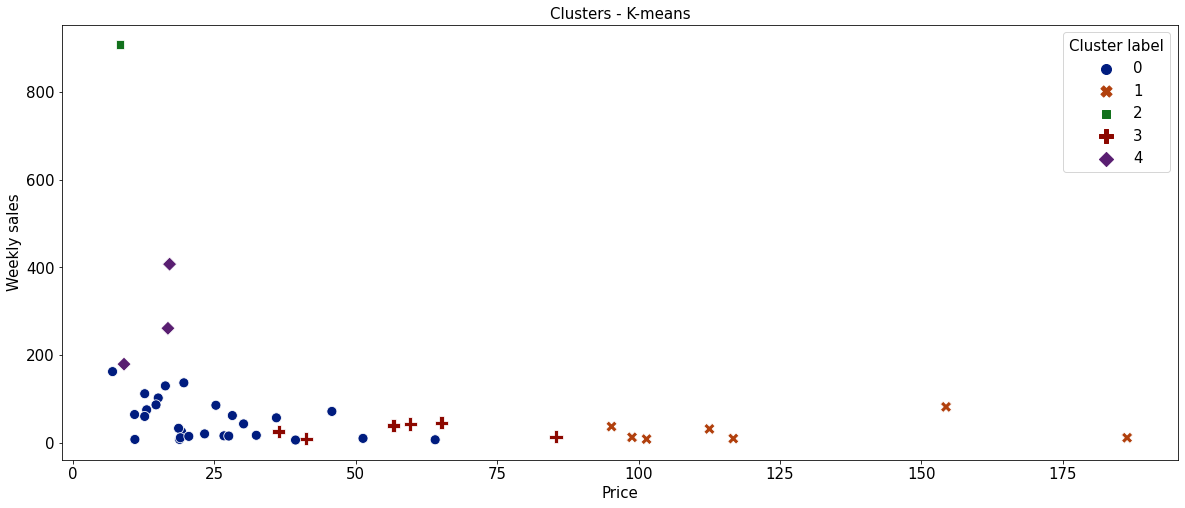

In [ ]:
## Build dataframe
list_prices=[]
list_sales=[]
for sku in skuSet:
  list_prices.append(np.mean(X_dict[sku]['train'][:,0], axis = 0))
  list_sales.append(np.mean([ [i] for i in y_dict[sku]['train'] ]))
df_clus=pd.DataFrame()
df_clus['price']=list_prices
df_clus['weekly_sales']=list_sales
df_clus['Cluster label']=kmeans.labels_
## Plot
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,8))
graph = sns.scatterplot(data=df_clus, x="price", y="weekly_sales", 
                        hue="Cluster label", style="Cluster label", palette="dark",
                        size="Cluster label", sizes=(100, 200))
plt.title('Clusters - K-means', fontsize=15)
plt.xlabel("Price")
plt.ylabel("Weekly sales")
plt.savefig("clusters_kmeans.png",dpi=400)
plt.show()

In [ ]:
df_clus['Cluster label'].value_counts()

0    27
1     7
3     6
4     3
2     1
Name: Cluster label, dtype: int64

## b) DBSCAN

Primer: how to re-label noisy points

In [ ]:
eps, ms = 0.05, 3

X_clus = np.zeros((len(skuSet), 2))
count = 0
for sku in skuSet:
   X_clus[count, :] = np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                axis=1),
                               axis = 0 )
   count += 1
X_clus = scaler.fit_transform(X_clus)

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)

clusters_dbscan=dbscan.labels_
print(clusters_dbscan)

[ 0  1  2  0  0  0  0 -1 -1 -1  0  1  0  0 -1  0  0  2  2  0  0  0  0  0
 -1  0  0  0  1 -1 -1 -1 -1  0  0  1  0  0  0 -1  0  0 -1  1]


In [ ]:
clusters_table=pd.DataFrame()
clusters_table['sku']=skuSet
clusters_table['clusters']=clusters_dbscan
clusters_table=clusters_table.transpose()
clusters_table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
sku,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
clusters,0,1,2,0,0,0,0,-1,-1,-1,0,1,0,0,-1,0,0,2,2,0,0,0,0,0,-1,0,0,0,1,-1,-1,-1,-1,0,0,1,0,0,0,-1,0,0,-1,1


In [ ]:
for i in range(len(clusters_dbscan)):
  if clusters_dbscan[i]==-1:
    clusters_dbscan[i]=max(clusters_dbscan)+1
print(clusters_dbscan)

[ 0  1  2  0  0  0  0  3  4  5  0  1  0  0  6  0  0  2  2  0  0  0  0  0
  7  0  0  0  1  8  9 10 11  0  0  1  0  0  0 12  0  0 13  1]


In [ ]:
clusters_table=pd.DataFrame()
clusters_table['sku']=skuSet
clusters_table['clusters']=clusters_dbscan
clusters_table=clusters_table.transpose()
clusters_table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
sku,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
clusters,0,1,2,0,0,0,0,3,4,5,0,1,0,0,6,0,0,2,2,0,0,0,0,0,7,0,0,0,1,8,9,10,11,0,0,1,0,0,0,12,0,0,13,1


### a) Average sales and price

We start by using only the means predictors.

Selection of best model:

In [ ]:
eps_values_ = list(np.arange(0.05,1,0.05))
min_samples_ = list(range(2,15))
params=[]
maximum_score=0
oos_r2=0

import random

#selection of parameters to test
random.seed(5)
eps_ = random.choices(eps_values_, k=50)
ms_ = random.choices(min_samples_, k=50)

## Iterations to find optimal parameter
for i in range (50):
    print('Model number:',i+1)
    eps = eps_[i]
    ms = ms_[i]
    print('  Parameters:',[eps,ms])
    #Clustering
    d = len(colnames) #d is the number of columns
    X_clus = np.zeros((len(skuSet), 2))
    count = 0
    for sku in skuSet:
        X_clus[count, :] = np.mean( np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                    np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                    axis=1),
                                    axis = 0 )
        count += 1
    X_clus = scaler.fit_transform(X_clus)
    dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
    clusters_dbscan=dbscan.labels_
    for i in range(len(clusters_dbscan)):
        if clusters_dbscan[i]==-1:
            clusters_dbscan[i]=max(clusters_dbscan)+1
    #Loop
    y_clus_pred = [] #y_clus_pred_sub
    y_clus_validation = [] #y_clus_test_sub
    for j in range(max(clusters_dbscan)+1):
        ##Get indices of items in cluster j 
        clus_items = list(np.where(clusters_dbscan == j)[0])
        ##Initialization 
        #X_sub
        X_clus_j_subtrain = X_dict_subsplit[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster 
        X_clus_j_validation = X_dict_subsplit[skuSet[clus_items[0]]]['test'] 
        #y_sub
        y_clus_j_subtrain = list(y_dict_subsplit[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster 
        y_clus_j_validation = list(y_dict_subsplit[skuSet[clus_items[0]]]['test']) 
        ##Loop 
        for idx in clus_items[1:]: #Iteration over items
            sku=skuSet[idx]
            #X_sub
            X_clus_j_subtrain = np.concatenate((X_clus_j_subtrain, X_dict_subsplit[sku]['train']), axis = 0)
            X_clus_j_validation = np.concatenate((X_clus_j_validation, X_dict_subsplit[sku]['test']), axis = 0)
            #y_sub
            y_clus_j_subtrain += list(y_dict_subsplit[sku]['train'])
            y_clus_j_validation += list(y_dict_subsplit[sku]['test'])
        ##Model
        model_clus_j_sub = LinearRegression().fit(X_clus_j_subtrain, y_clus_j_subtrain)
        y_clus_pred += list(model_clus_j_sub.predict(X_clus_j_validation))
        y_clus_validation += y_clus_j_validation

    #Comparison of results
    score=r2_score(np.array(y_clus_validation), np.array(y_clus_pred))
    print('  Validation R2:', score)
    if score > maximum_score:
        params = [eps,ms]
        maximum_score = score

#### Test on fresh data ####

eps, ms = params
#Clustering
d = len(colnames) #d is the number of columns
X_clus = np.zeros((len(skuSet), 2))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                 np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                 axis=1),
                                axis = 0 )
    count += 1
X_clus = scaler.fit_transform(X_clus)
dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
clusters_dbscan=dbscan.labels_
for i in range(len(clusters_dbscan)):
  if clusters_dbscan[i]==-1:
    clusters_dbscan[i]=max(clusters_dbscan)+1
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(max(clusters_dbscan)+1):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(clusters_dbscan == j)[0])
    ##Initialization 
    #X
    X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
    X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
    #y
    y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
    y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
        sku=skuSet[idx]
        #X
        X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
        X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
        #y
        y_clus_j_train += list(y_dict[sku]['train'])
        y_clus_j_test += list(y_dict[sku]['test'])
    ##Model
    model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
    y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
    y_clus_test += y_clus_j_test
#Results
oos_r2=r2_score(y_clus_test, y_clus_pred)

#### Print Results ####

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:',oos_r2)

Model number: 1
  Parameters: [0.6000000000000001, 6]
  Validation R2: -0.007617107467217998
Model number: 2
  Parameters: [0.7500000000000001, 6]
  Validation R2: -0.007617107467217998
Model number: 3
  Parameters: [0.8, 12]
  Validation R2: -0.007617107467217998
Model number: 4
  Parameters: [0.9000000000000001, 8]
  Validation R2: -0.007617107467217998
Model number: 5
  Parameters: [0.7500000000000001, 6]
  Validation R2: -0.007617107467217998
Model number: 6
  Parameters: [0.9000000000000001, 8]
  Validation R2: -0.007617107467217998
Model number: 7
  Parameters: [0.05, 11]
  Validation R2: 0.09263739865556941
Model number: 8
  Parameters: [0.45, 2]
  Validation R2: 0.23652683941617336
Model number: 9
  Parameters: [0.9000000000000001, 14]
  Validation R2: -0.007617107467217998
Model number: 10
  Parameters: [0.6500000000000001, 2]
  Validation R2: -0.007617107467217998
Model number: 11
  Parameters: [0.9000000000000001, 11]
  Validation R2: -0.007617107467217998
Model number: 12
 

Final Model:

In [ ]:
tZero=time.time()

eps, ms = 0.2, 3
#Clustering
d = len(colnames) #d is the number of columns
X_clus = np.zeros((len(skuSet), 2))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                 np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                 axis=1),
                                axis = 0 )
    count += 1
X_clus = scaler.fit_transform(X_clus)
dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
clusters_dbscan=dbscan.labels_
for i in range(len(clusters_dbscan)):
  if clusters_dbscan[i]==-1:
    clusters_dbscan[i]=max(clusters_dbscan)+1
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(max(clusters_dbscan)+1):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(clusters_dbscan == j)[0])
    ##Initialization 
    #X
    X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
    X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
    #y
    y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
    y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
        sku=skuSet[idx]
        #X
        X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
        X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
        #y
        y_clus_j_train += list(y_dict[sku]['train'])
        y_clus_j_test += list(y_dict[sku]['test'])
    ##Model
    model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
    y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
    y_clus_test += y_clus_j_test

#Results
print('OOS R2:',r2_score(y_clus_test, y_clus_pred))

t = time.time()-tZero
print("Time to compute",t)

OOS R2: 0.5438527844309133
Time to compute 0.03587770462036133


In [ ]:
res['DBSCAN - average']=[r2_score(y_clus_test, y_clus_pred)]
res

,K-means - average,K-means - average & stdev,DBSCAN - average
R2,0.566148,0.559736,0.543853


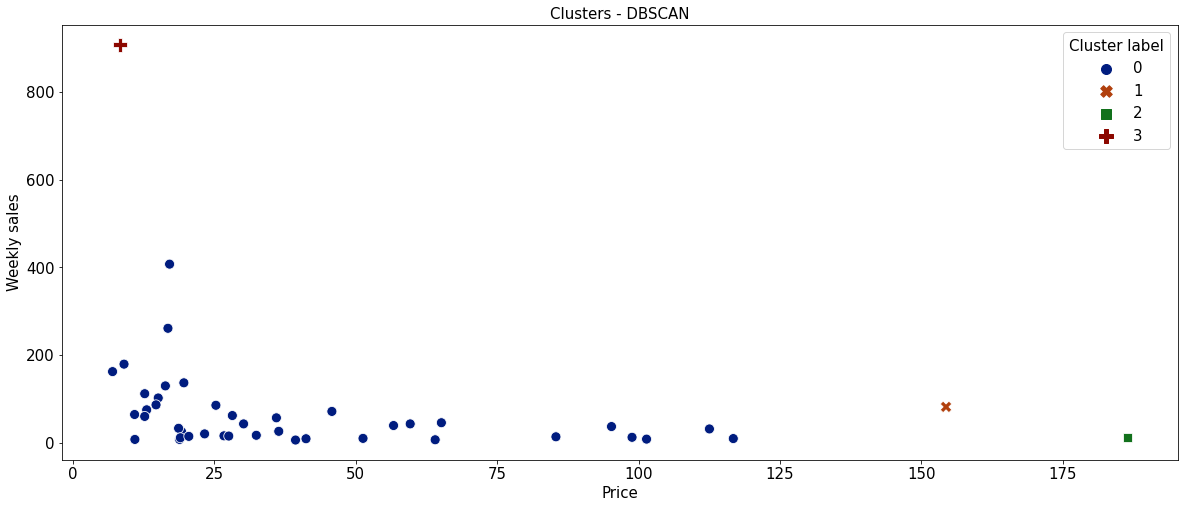

In [ ]:
## Build dataframe
list_prices=[]
list_sales=[]
for sku in skuSet:
  list_prices.append(np.mean(X_dict[sku]['train'][:,0], axis = 0))
  list_sales.append(np.mean([ [i] for i in y_dict[sku]['train'] ]))
df_clus=pd.DataFrame()
df_clus['price']=list_prices
df_clus['weekly_sales']=list_sales
df_clus['Cluster label']=clusters_dbscan
## Plot
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,8))
graph = sns.scatterplot(data=df_clus, x="price", y="weekly_sales", 
                        hue="Cluster label", style="Cluster label", palette="dark",
                        size="Cluster label", sizes=(100, 200))
plt.title('Clusters - DBSCAN', fontsize=15)
plt.xlabel("Price")
plt.ylabel("Weekly sales")
plt.savefig("clusters_dbscan.png",dpi=400)
plt.show()

### a) Average and stdev sales and price

Selection of best model:

In [ ]:
eps_values_ = list(np.arange(0.05,1,0.05))
min_samples_ = list(range(2,15))
params=[]
maximum_score=0
oos_r2=0

import random

#selection of parameters to test
random.seed(5)
eps_ = random.choices(eps_values_, k=50)
ms_ = random.choices(min_samples_, k=50)

## Iterations to find optimal parameter
for i in range (50):
    print('Model number:',i+1)
    eps = eps_[i]
    ms = ms_[i]
    print('  Parameters:',[eps,ms])
    #Clustering
    d = len(colnames) #d is the number of columns
    X_clus = np.zeros((len(skuSet), 4))
    count = 0
    for sku in skuSet:
        X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                                      np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                                      axis=1),
                                                    axis = 0 ), 
                                            
                                            np.std(  np.concatenate(( np.array( [ [i] for i in X_dict_subsplit[sku]['train'][:,0] ] ), 
                                                                      np.array( [ [i] for i in y_dict_subsplit[sku]['train'] ] )),
                                                                      axis=1), 
                                                    axis = 0)), 
                                          
                                            axis=0)
        count += 1
    X_clus = scaler.fit_transform(X_clus)
    dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
    clusters_dbscan=dbscan.labels_
    for i in range(len(clusters_dbscan)):
        if clusters_dbscan[i]==-1:
            clusters_dbscan[i]=max(clusters_dbscan)+1
    #Loop
    y_clus_pred = [] #y_clus_pred_sub
    y_clus_validation = [] #y_clus_test_sub
    for j in range(max(clusters_dbscan)+1):
        ##Get indices of items in cluster j 
        clus_items = list(np.where(clusters_dbscan == j)[0])
        ##Initialization 
        #X_sub
        X_clus_j_subtrain = X_dict_subsplit[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster 
        X_clus_j_validation = X_dict_subsplit[skuSet[clus_items[0]]]['test'] 
        #y_sub
        y_clus_j_subtrain = list(y_dict_subsplit[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster 
        y_clus_j_validation = list(y_dict_subsplit[skuSet[clus_items[0]]]['test']) 
        ##Loop 
        for idx in clus_items[1:]: #Iteration over items
            sku=skuSet[idx]
            #X_sub
            X_clus_j_subtrain = np.concatenate((X_clus_j_subtrain, X_dict_subsplit[sku]['train']), axis = 0)
            X_clus_j_validation = np.concatenate((X_clus_j_validation, X_dict_subsplit[sku]['test']), axis = 0)
            #y_sub
            y_clus_j_subtrain += list(y_dict_subsplit[sku]['train'])
            y_clus_j_validation += list(y_dict_subsplit[sku]['test'])
        ##Model
        model_clus_j_sub = LinearRegression().fit(X_clus_j_subtrain, y_clus_j_subtrain)
        y_clus_pred += list(model_clus_j_sub.predict(X_clus_j_validation))
        y_clus_validation += y_clus_j_validation

    #Comparison of results
    score=r2_score(np.array(y_clus_validation), np.array(y_clus_pred))
    print('  Validation R2:', score)
    if score > maximum_score:
        params = [eps,ms]
        maximum_score = score

#### Test on fresh data ####

eps, ms = params
#Clustering
d = len(colnames) #d is the number of columns
X_clus = np.zeros((len(skuSet), 4))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
X_clus = scaler.fit_transform(X_clus)
dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
clusters_dbscan=dbscan.labels_
for i in range(len(clusters_dbscan)):
  if clusters_dbscan[i]==-1:
    clusters_dbscan[i]=max(clusters_dbscan)+1
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(max(clusters_dbscan)+1):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(clusters_dbscan == j)[0])
    ##Initialization 
    #X
    X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
    X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
    #y
    y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
    y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
        sku=skuSet[idx]
        #X
        X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
        X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
        #y
        y_clus_j_train += list(y_dict[sku]['train'])
        y_clus_j_test += list(y_dict[sku]['test'])
    ##Model
    model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
    y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
    y_clus_test += y_clus_j_test
#Results
oos_r2=r2_score(y_clus_test, y_clus_pred)

#### Print Results ####

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:',oos_r2)

Model number: 1
  Parameters: [0.6000000000000001, 6]
  Validation R2: 0.23652683941617336
Model number: 2
  Parameters: [0.7500000000000001, 6]
  Validation R2: 0.23652683941617336
Model number: 3
  Parameters: [0.8, 12]
  Validation R2: 0.23652683941617336
Model number: 4
  Parameters: [0.9000000000000001, 8]
  Validation R2: -0.007617107467217998
Model number: 5
  Parameters: [0.7500000000000001, 6]
  Validation R2: 0.23652683941617336
Model number: 6
  Parameters: [0.9000000000000001, 8]
  Validation R2: -0.007617107467217998
Model number: 7
  Parameters: [0.05, 11]
  Validation R2: 0.09263739865556941
Model number: 8
  Parameters: [0.45, 2]
  Validation R2: 0.23652683941617336
Model number: 9
  Parameters: [0.9000000000000001, 14]
  Validation R2: -0.007617107467217998
Model number: 10
  Parameters: [0.6500000000000001, 2]
  Validation R2: 0.23652683941617336
Model number: 11
  Parameters: [0.9000000000000001, 11]
  Validation R2: -0.007617107467217998
Model number: 12
  Parameter

Final Model:

In [ ]:
tZero=time.time()

eps, ms = 0.3, 2
#Clustering
X_clus = np.zeros((len(skuSet), 4))
count = 0
for sku in skuSet:
    X_clus[count, :] = np.concatenate( (np.mean( np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1),
                                                 axis = 0 ), 
                                        
                                        np.std(  np.concatenate(( np.array( [ [i] for i in X_dict[sku]['train'][:,0] ] ), 
                                                                  np.array( [ [i] for i in y_dict[sku]['train'] ] )),
                                                                  axis=1), 
                                                 axis = 0)), 
                                      
                                        axis=0)
    count += 1
X_clus = scaler.fit_transform(X_clus)
dbscan = DBSCAN(eps=eps, min_samples = ms).fit(X_clus)
clusters_dbscan=dbscan.labels_
for i in range(len(clusters_dbscan)):
  if clusters_dbscan[i]==-1:
    clusters_dbscan[i]=max(clusters_dbscan)+1
#Loop
y_clus_pred = []
y_clus_test = []
for j in range(max(clusters_dbscan)+1):
    ##Get indices of items in cluster j 
    clus_items = list(np.where(clusters_dbscan == j)[0])
    ##Initialization 
    #X
    X_clus_j_train = X_dict[skuSet[clus_items[0]]]['train'] #initialization with first item of the cluster
    X_clus_j_test = X_dict[skuSet[clus_items[0]]]['test']
    #y
    y_clus_j_train = list(y_dict[skuSet[clus_items[0]]]['train']) #initialization with first item of the cluster
    y_clus_j_test = list(y_dict[skuSet[clus_items[0]]]['test'])
    ##Loop 
    for idx in clus_items[1:]: #Iteration over items
        sku=skuSet[idx]
        #X
        X_clus_j_train = np.concatenate((X_clus_j_train, X_dict[sku]['train']), axis = 0) #Bringing together the training set for the cluster
        X_clus_j_test = np.concatenate((X_clus_j_test, X_dict[sku]['test']), axis = 0)
        #y
        y_clus_j_train += list(y_dict[sku]['train'])
        y_clus_j_test += list(y_dict[sku]['test'])
    ##Model
    model_clus_j = LinearRegression().fit(X_clus_j_train, y_clus_j_train)
    y_clus_pred += list(model_clus_j.predict(X_clus_j_test))
    y_clus_test += y_clus_j_test

#Results
print('OOS R2:',r2_score(y_clus_test, y_clus_pred))

t = time.time()-tZero
print("Time to compute",t)

OOS R2: 0.5449664923782697
Time to compute 0.04873394966125488


In [ ]:
res['DBSCAN - average & stdev']=[r2_score(y_clus_test, y_clus_pred)]
res

,K-means - average,K-means - average & stdev,DBSCAN - average,DBSCAN - average & stdev
R2,0.566148,0.559736,0.543853,0.544966
